# Machine Learning Demo Spline interoplation

In [1]:
# %pylab inline
%matplotlib inline
import cv2
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button
import matplotlib as mpl
from matplotlib import pyplot as plt
import scipy.interpolate as inter
import numpy as np
import math

plt.rcParams['figure.figsize'] = (15.0, 10.0)

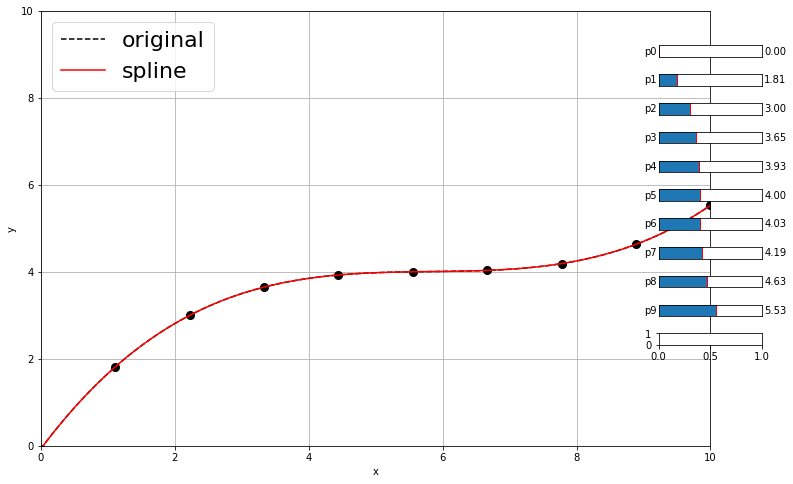

In [2]:
func = lambda x: 0.02*(x-6)**3+0.01*(x-5)**2+4

#get a list of points to fit a spline to as well
N = 10
xmin = 0 
xmax = 10 
x = np.linspace(xmin,xmax,N)

#spline fit
yvals = func(x)
spline = inter.InterpolatedUnivariateSpline (x, yvals)

#figure.subplot.right
#mpl.rcParams['figure.subplot.right'] = 0.8
plt.rcParams['figure.figsize'] = (12.0, 8.0)
#set up a plot
fig,axes = plt.subplots(1,1,sharex=True)
ax1 = axes


pind = None #active point
epsilon = 5 #max pixel distance

def update(val):
    global yvals
    global spline
    # update curve
    for i in np.arange(N):
      yvals[i] = sliders[i].val 
    l.set_ydata(yvals)
    spline = inter.InterpolatedUnivariateSpline (x, yvals)
    m.set_ydata(spline(X))
    # redraw canvas while idle
    fig.canvas.draw_idle()

def reset(event):
    global yvals
    global spline
    #reset the values
    yvals = func(x)
    for i in np.arange(N):
      sliders[i].reset()
    spline = inter.InterpolatedUnivariateSpline (x, yvals)
    l.set_ydata(yvals)
    m.set_ydata(spline(X))
    # redraw canvas while idle
    fig.canvas.draw_idle()

def button_press_callback(event):
    'whenever a mouse button is pressed'
    global pind
    if event.inaxes is None:
        return
    if event.button != 1:
        return
    #print(pind)
    pind = get_ind_under_point(event)    

def button_release_callback(event):
    'whenever a mouse button is released'
    global pind
    if event.button != 1:
        return
    pind = None

def get_ind_under_point(event):
    'get the index of the vertex under point if within epsilon tolerance'

    # display coords
    #print('display x is: {0}; display y is: {1}'.format(event.x,event.y))
    t = ax1.transData.inverted()
    tinv = ax1.transData 
    xy = t.transform([event.x,event.y])
    #print('data x is: {0}; data y is: {1}'.format(xy[0],xy[1]))
    xr = np.reshape(x,(np.shape(x)[0],1))
    yr = np.reshape(yvals,(np.shape(yvals)[0],1))
    xy_vals = np.append(xr,yr,1)
    xyt = tinv.transform(xy_vals)
    xt, yt = xyt[:, 0], xyt[:, 1]
    d = np.hypot(xt - event.x, yt - event.y)
    indseq, = np.nonzero(d == d.min())
    ind = indseq[0]

    #print(d[ind])
    if d[ind] >= epsilon:
        ind = None

    #print(ind)
    return ind

def motion_notify_callback(event):
    'on mouse movement'
    global yvals
    if pind is None:
        return
    if event.inaxes is None:
        return
    if event.button != 1:
        return

    #update yvals
    #print('motion x: {0}; y: {1}'.format(event.xdata,event.ydata))
    yvals[pind] = event.ydata 

    # update curve via sliders and draw
    sliders[pind].set_val(yvals[pind])
    fig.canvas.draw_idle()

X = np.arange(0,xmax+1,0.1)
ax1.plot (X, func(X), 'k--', label='original')
l, = ax1.plot (x,yvals,color='k',linestyle='none',marker='o',markersize=8)
m, = ax1.plot (X, spline(X), 'r-', label='spline')



ax1.set_yscale('linear')
ax1.set_xlim(0, xmax)
ax1.set_ylim(0,xmax)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=2,prop={'size':22})

sliders = []

for i in np.arange(N):

    axamp = plt.axes([0.84, 0.8-(i*0.05), 0.12, 0.02])
    # Slider
    s = Slider(axamp, 'p{0}'.format(i), 0, 10, valinit=yvals[i])
    sliders.append(s)


for i in np.arange(N):
    #samp.on_changed(update_slider)
    sliders[i].on_changed(update)

axres = plt.axes([0.84, 0.8-((N)*0.05), 0.12, 0.02])
#bres = Button(axres, 'Reset')
#bres.on_clicked(reset)

fig.canvas.mpl_connect('button_press_event', button_press_callback)
fig.canvas.mpl_connect('button_release_event', button_release_callback)
fig.canvas.mpl_connect('motion_notify_event', motion_notify_callback)

plt.show()


# '''Reference : https://matplotlib.org/2.2.2/gallery/event_handling/poly_editor.html?highlight=polygoninteractor'''


## It gives similar results to polynomial interpolation with low degree. Spline interpolation avoids the problem of Runge's phenomenon (overfitting), in which oscillation can occur between points when interpolating using high degree polynomials.



## Given a random-sampled selection of pixels from an image, spline interpolation could be used to interpolate back to a representation of the original image. 


## Bilinear interpolation considers the closest 2x2 neighborhood of known pixel values surrounding the unknown pixel. It then takes a weighted average of these 4 pixels to arrive at its final interpolated value. This results in much smoother looking images than nearest neighbor.

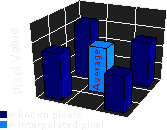

## Bicubic has 4x4

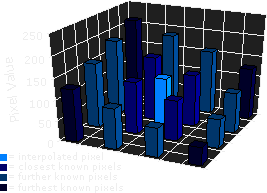

Source: https://www.cambridgeincolour.com/tutorials/image-interpolation.htm

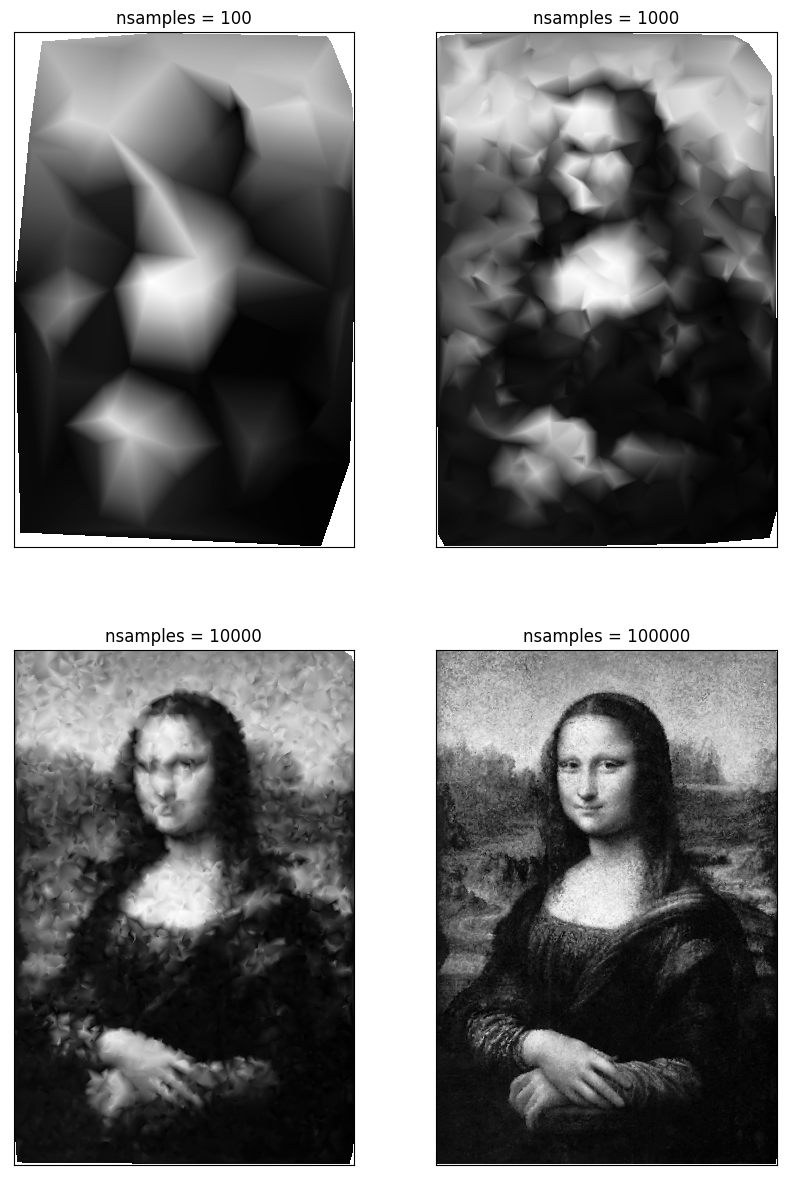

In [3]:
# img_interp.py
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from PIL import Image

def make_interpolated_image(nsamples):
    """Make an interpolated image from a random selection of pixels.

    Take nsamples random pixels from im and reconstruct the image using
    scipy.interpolate.griddata.

    """

    ix = np.random.randint(im.shape[1], size=nsamples)
    iy = np.random.randint(im.shape[0], size=nsamples)
    samples = im[iy,ix]
    int_im = griddata((iy, ix), samples, (Y, X))
    return int_im

# Read in image and convert to greyscale array object
img = Image.open('mona-lisa.jpg')
im = np.array(img.convert('L'))

# A meshgrid of pixel coordinates
nx, ny = im.shape[1], im.shape[0]
X, Y = np.meshgrid(np.arange(0, nx, 1), np.arange(0, ny, 1))

# Create a figure of nrows x ncols subplots, and orient it appropriately
# for the aspect ratio of the image.
nrows, ncols = 2,2
plt.rcParams['figure.figsize'] = (15.0, 10.0)
fig, ax = plt.subplots(nrows, ncols, dpi=100)
if nx < ny:
    w, h = fig.get_figwidth(), fig.get_figheight()
    fig.set_figwidth(h), fig.set_figheight(w)

# Convert an integer i to coordinates in the ax array
get_indices = lambda i: (i // nrows, i % ncols)



# Sample 100, 1,000, 10,000 and 100,000 points and plot the interpolated
# images in the figure
for i in range(4):
    nsamples = 10**(i+2)
    axes = ax[get_indices(i)]
    axes.imshow(make_interpolated_image(nsamples),
                          cmap=plt.get_cmap('Greys_r'))
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_title('nsamples = {0:d}'.format(nsamples))


plt.show()



In [4]:
from ipywidgets import interact, widgets
from IPython.display import display
import matplotlib.pyplot as plt

# img_interp.py
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from skimage.morphology import disk
from skimage.filters import rank
from skimage.color import rgb2gray
import skimage.data

# img_interp.py
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from PIL import Image

# Read in image and convert to greyscale array object
img = Image.open('mona-lisa.jpg')
im = np.array(img.convert('L'))

# A meshgrid of pixel coordinates
nx, ny = im.shape[1], im.shape[0]
X, Y = np.meshgrid(np.arange(0, nx, 1), np.arange(0, ny, 1))


def make_interpolated_image(nsamples):
    """Make an interpolated image from a random selection of pixels.

    Take nsamples random pixels from im and reconstruct the image using
    scipy.interpolate.griddata.

    """

    ix = np.random.randint(im.shape[1], size=nsamples)
    iy = np.random.randint(im.shape[0], size=nsamples)
    samples = im[iy,ix]
    int_im = griddata((iy, ix), samples, (Y, X))
    return int_im



def f(y):
    bicubic_monalisa = make_interpolated_image(y)
    #plt.rcParams['figure.figsize'] = (15.0, 10.0)
    
    plt.imshow(bicubic_monalisa)
    
plt.rcParams['figure.figsize'] = (15.0, 10.0)  
    
img = Image.open('mona-lisa.jpg')
img_mona = np.array(img.convert('L'))
#     image = skimage.data.camera() #plt.imread("Test.png")       
# img_gray = rgb2gray(image)

# fig = plt.figure(figsize=(6, 4))
ax_orig = fig.add_subplot(121) 
ax_neu = fig.add_subplot(122) 

ax_orig.imshow(img_mona, cmap="gray")
ax_neu.imshow(img_mona, cmap="gray")


In [5]:
s1=interact(f, y=widgets.IntSlider(min=10,max=100000,step=2,value=10));
display(s1)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0xMCwgZGVzY3JpcHRpb249dSd5JywgbWF4PTEwMDAwMCwgbWluPTEwLCBzdGVwPTIpLCBPdXRwdXQoKSksIF9kb21fY2xhc3PigKY=


<function __main__.f>

# The active contour model is a method to fit open or closed splines to lines or edges in an image 

[0, 512, 512, 0]

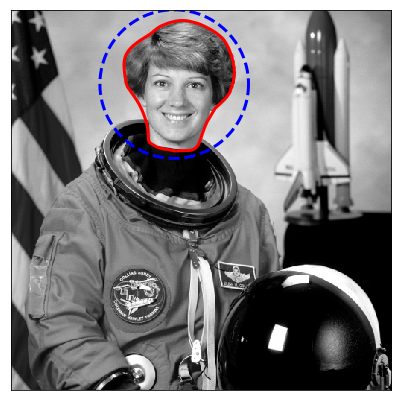

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour


img = data.astronaut()
img = rgb2gray(img)

s = np.linspace(0, 2*np.pi, 400)
x = 220 + 100*np.cos(s)
y = 100 + 100*np.sin(s)
init = np.array([x, y]).T

snake = active_contour(gaussian(img, 3),
                       init, alpha=0.015, beta=10, gamma=0.001)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--b', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-r', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

# Image Interpolation for Upsizing and smoothening

In [7]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://upload.wikimedia.org/wikipedia/commons/9/90/Comparison_of_1D_and_2D_interpolation.svg")

## Bilinear interpolation works by interpolating pixel color values, introducing a continuous transition into the output even where the original material has discrete transitions.

In [8]:
import cv2
import numpy as np


img_apple = cv2.imread('apple.jpg')
bicubic_img_apple = cv2.resize(img_apple,None, fx = 20, fy = 20, interpolation = cv2.INTER_CUBIC)


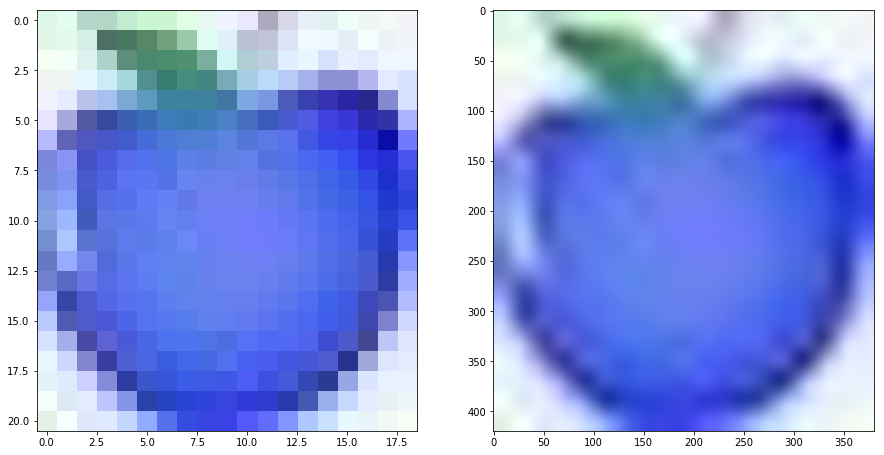

In [9]:

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img_apple)
axarr[1].imshow(bicubic_img_apple)
plt.show()

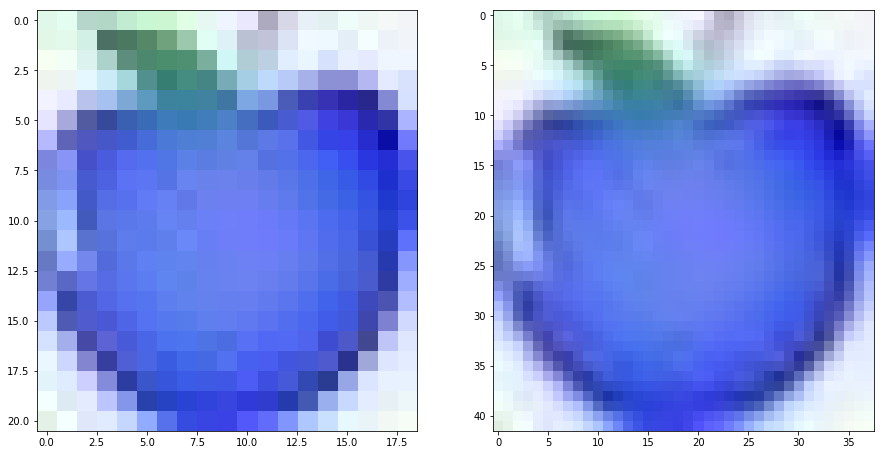

In [10]:
bicubic_img_apple = cv2.resize(img_apple,None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
# plt.rcParams['figure.figsize'] = (15.0, 10.0)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img_apple)
axarr[1].imshow(bicubic_img_apple)
plt.show()


In [11]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [12]:
# %%capture
# %matplotlib inline
from ipywidgets import interact, widgets
from IPython.display import display
import matplotlib.pyplot as plt

from skimage.morphology import disk
from skimage.filters import rank
from skimage.color import rgb2gray
import skimage.data


def f(x):
    bicubic_img_apple = cv2.resize(img_apple,None, fx = x, fy = x, interpolation = cv2.INTER_CUBIC)
    #plt.rcParams['figure.figsize'] = (15.0, 10.0)
    
    plt.imshow(bicubic_img_apple)
    
    
img_apple = cv2.imread('apple.jpg')
#     image = skimage.data.camera() #plt.imread("Test.png")       
# img_gray = rgb2gray(image)
# plt.rcParams['figure.figsize'] = (15,15)
# fig = plt.figure(figsize=(15,15))
ax_orig = fig.add_subplot(121) 
ax_neu = fig.add_subplot(122) 

ax_orig.imshow(img_apple, cmap="gray")
ax_neu.imshow(img_apple, cmap="gray")

In [14]:
plt.rcParams['figure.figsize'] = (15.0, 10.0)
s1=interact(f, x=widgets.IntSlider(min=1,max=11,step=1,value=1));
display(s1)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0xLCBkZXNjcmlwdGlvbj11J3gnLCBtYXg9MTEsIG1pbj0xKSwgT3V0cHV0KCkpLCBfZG9tX2NsYXNzZXM9KHUnd2lkZ2V0LWnigKY=


<function __main__.f>

## Conclusion
### 1] No training required <br>
### 2] Fast due to easy tridiagonal matrix result of equations <br>
### 3] Objective is to fit most of the points unlike regression where objective is to minimize distance <br>
### 4] Reduces overfitting by decreasing degree of curve